### Random Forest Model

In [8]:
# imports libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             roc_curve)
import warnings
import joblib
import numpy as np
warnings.filterwarnings('ignore')

In [9]:
# load the preprocessed dataset
df = pd.read_csv("./datasets/nlp.csv")
print("Dataset shape:", df.shape)
print("First 5 rows:")
df.head()

Dataset shape: (251562, 34)
First 5 rows:


,Diastolic_BP,Physical_Activity_Level,Family_History,Diabetes,Stress_Level,Gender,Education_Level,Country_Argentina,Country_Australia,Country_Brazil,...,Country_Turkey,Country_UK,Country_USA,Smoking_Status_Current,Smoking_Status_Former,Smoking_Status_Never,Employment_Status_Employed,Employment_Status_Retired,Employment_Status_Unemployed,Hypertension
0,79,0,1,1,9,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
1,84,2,1,1,6,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
2,60,2,1,1,5,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,94,1,1,1,6,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,97,1,1,0,6,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [10]:
# prepare features and target
X = df.drop('Hypertension', axis=1) # features
y = df['Hypertension'] # target

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# print the shape
print("Training Data")
print(f"set shape: {X_train.shape}")
print(f"Class distribution: {y_train.value_counts()}")

print("\n")

print("Test Data")
print(f"shape: {X_test.shape}")
print(f"Class distribution: {y_test.value_counts()}")

Training Data
set shape: (201249, 33)
Class distribution: Hypertension
1    100625
0    100624
Name: count, dtype: int64


Test Data
shape: (50313, 33)
Class distribution: Hypertension
0    25157
1    25156
Name: count, dtype: int64


In [28]:
# Model 1: baseline (with all features)
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# evaluate baseline model
y_pred_baseline = baseline_rf.predict(X_test)
y_prob_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# calculate metrics
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1 Score': f1_score(y_test, y_pred_baseline),
    'AUC-ROC': roc_auc_score(y_test, y_prob_baseline)
}

# print baseline metrics
print("Baseline Random Forest Performance:")
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

Baseline Random Forest Performance:
Accuracy: 0.7518
Precision: 0.7109
Recall: 0.8488
F1 Score: 0.7738
AUC-ROC: 0.7997


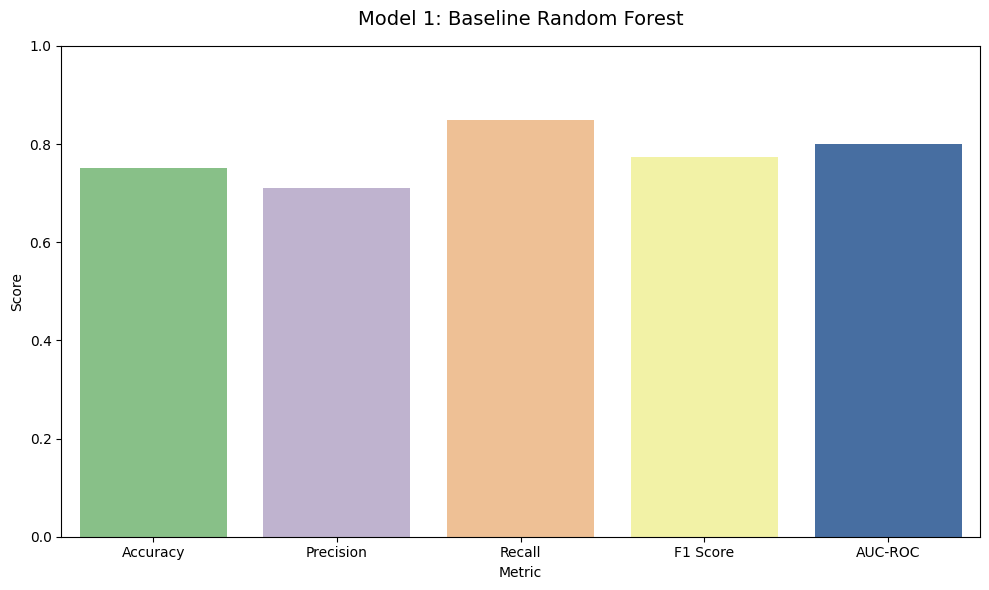

In [29]:
# Plot baseline metrics
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame(list(baseline_metrics.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='Accent')
plt.title('Model 1: Baseline Random Forest', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('./results/eda/random_forest_baseline_metrics.png')
plt.show()

In [13]:
# Save the baseline model
joblib.dump(baseline_rf, './results/models/random_forest_model_baseline.pkl')

['./results/models/random_forest_model_baseline.pkl']

In [ ]:
# Model 2: tuned (with all features)
# define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],         # limit depth
    'min_samples_split': [5, 10],     # increase split
    'min_samples_leaf': [4, 6, 8],     # prevent small leaves
    'max_features': ['sqrt', 'log2']
}

cross_val = 3

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',
    cv=cross_val,
    n_jobs=-1,
    verbose=1
)

# Sample from all features for tuning
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42
)

# perform tuning
grid_search.fit(X_sample, y_sample)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train model with best parameters
tuned_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
tuned_rf.fit(X_train, y_train)

# evaluate the tuned model
y_pred_tuned = tuned_rf.predict(X_test)
y_prob_tuned = tuned_rf.predict_proba(X_test)[:, 1]

# calculate metrics
tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1 Score': f1_score(y_test, y_pred_tuned),
    'AUC-ROC': roc_auc_score(y_test, y_prob_tuned)
}

print("\nTuned Random Forest Performance:")
for metric, value in tuned_metrics.items():
    print(f"{metric}: {value:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters found by GridSearchCV:
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}

Tuned Random Forest Performance:
Accuracy: 0.7777
Precision: 0.6945
Recall: 0.9917
F1 Score: 0.8169
AUC-ROC: 0.7955


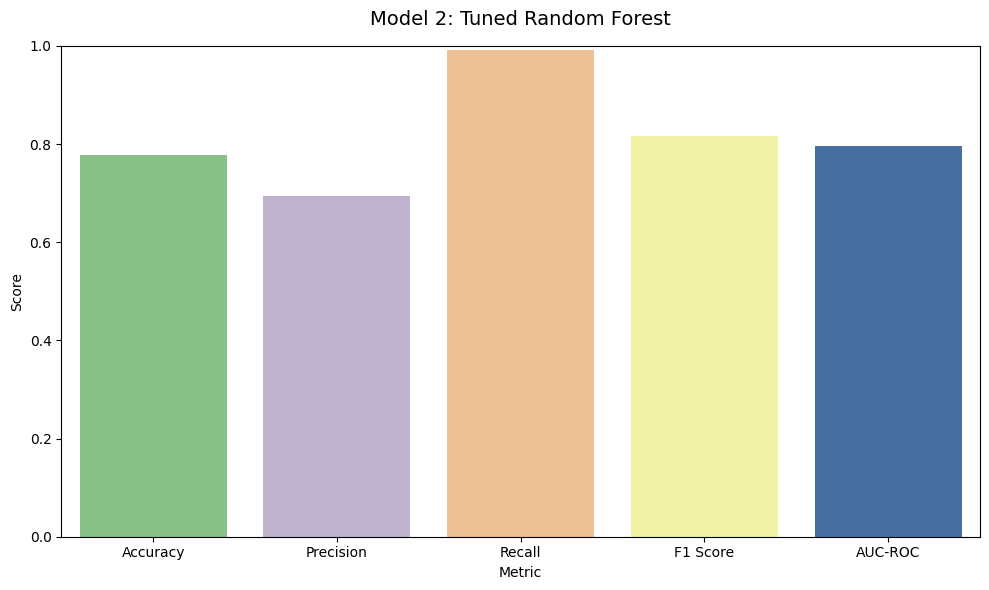

In [15]:
# plot tuned metrics
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame(list(tuned_metrics.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='Accent')
plt.title('Model 2: Tuned Random Forest', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.tight_layout()
plt.savefig('./results/eda/random_forest_tuned_metrics.png')
plt.show()

Comparison: Baseline vs Tuned
      Metric  Baseline     Tuned
0   Accuracy  0.751834  0.777712
1  Precision  0.710928  0.694488
2     Recall  0.848784  0.991652
3   F1 Score  0.773763  0.816884
4    AUC-ROC  0.799659  0.795495


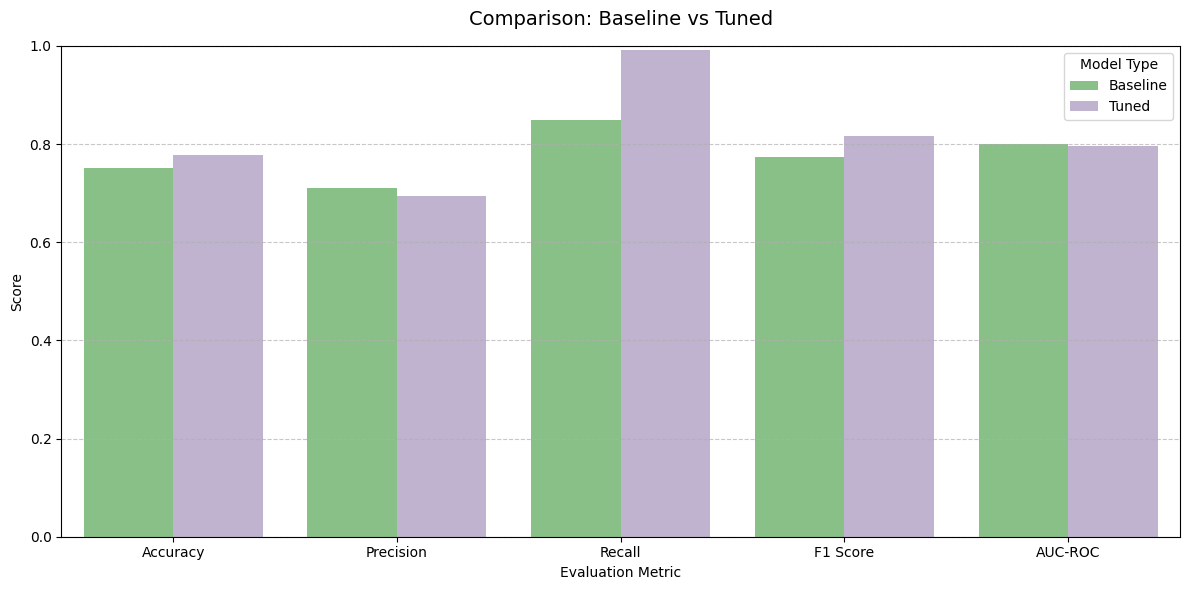

In [16]:
# comparison baseline vs tuned
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
    'Baseline': [
        baseline_metrics['Accuracy'],
        baseline_metrics['Precision'],
        baseline_metrics['Recall'],
        baseline_metrics['F1 Score'],
        baseline_metrics['AUC-ROC']
    ],
    'Tuned': [
        tuned_metrics['Accuracy'],
        tuned_metrics['Precision'],
        tuned_metrics['Recall'],
        tuned_metrics['F1 Score'],
        tuned_metrics['AUC-ROC']
    ]
})

print("Comparison: Baseline vs Tuned")
print(comparison)

# Plot comparison
plt.figure(figsize=(12, 6))
comparison_melted = comparison.melt(id_vars='Metric', var_name='Model', value_name='Score')
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='Accent')
plt.title('Comparison: Baseline vs Tuned', fontsize=14, pad=15)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/random_forest_comparison.png')
plt.show()

In [17]:
# Function to evaluate underfitting/overfitting
def evaluate_model_fit(model, X_train, y_train, X_test, y_test, model_name):
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Calculate overfitting gap
    gap = train_acc - test_acc
    
    # Determine fit status
    if gap > 0.15:
        status = "Overfitting"
    elif train_acc < 0.7 and test_acc < 0.7:
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    # Create results dataframe
    results = pd.DataFrame({
        'Model': [model_name],
        'Training Accuracy': [train_acc],
        'Test Accuracy': [test_acc],
        'Gap': [gap],
        'Status': [status]
    })
    
    return results

In [18]:
# Evaluate baseline model fit
baseline_fit = evaluate_model_fit(
    baseline_rf, X_train, y_train, X_test, y_test, 
    "Baseline Random Forest"
)
print("Baseline Model Fit Analysis:")
print(baseline_fit)

Baseline Model Fit Analysis:
                    Model  Training Accuracy  Test Accuracy       Gap  \
0  Baseline Random Forest           0.997148       0.751834  0.245314   

        Status  
0  Overfitting  


In [19]:
# Evaluate tuned model fit
tuned_fit = evaluate_model_fit(
    tuned_rf, X_train, y_train, X_test, y_test, 
    "Tuned Random Forest"
)
print("\nTuned Model Fit Analysis:")
print(tuned_fit)


Tuned Model Fit Analysis:
                 Model  Training Accuracy  Test Accuracy       Gap    Status
0  Tuned Random Forest           0.782374       0.777712  0.004663  Good Fit


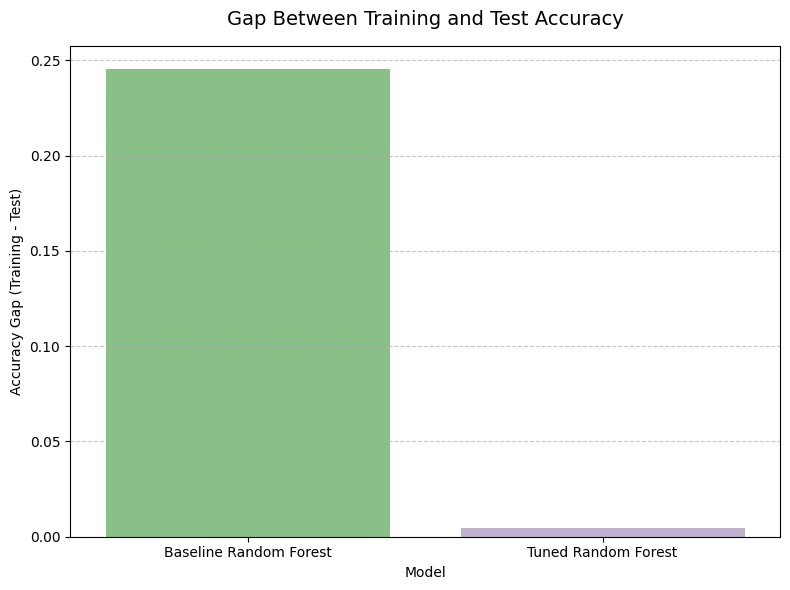

In [20]:
# Simple gap visualization between training and test accuracy
fit_results = pd.concat([baseline_fit, tuned_fit], ignore_index=True)

# Create a simple bar chart showing the gap
plt.figure(figsize=(8, 6))
sns.barplot(data=fit_results, x='Model', y='Gap', palette='Accent')
plt.title('Gap Between Training and Test Accuracy', fontsize=14, pad=15)
plt.ylabel('Accuracy Gap (Training - Test)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/random_forest_simple_gap.png')
plt.show()

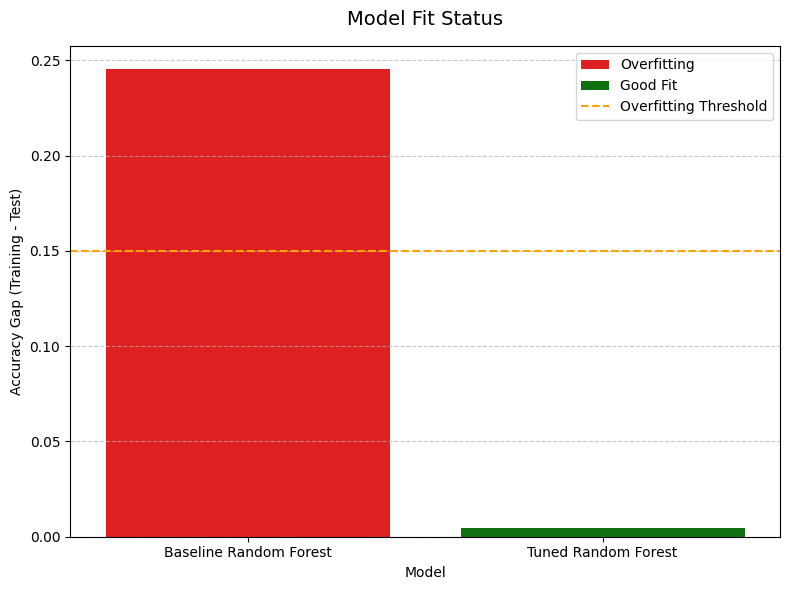

In [21]:
# Simple fit status visualization
plt.figure(figsize=(8, 6))

# Create a bar plot with status colors
status_colors = {'Good Fit': 'green', 'Overfitting': 'red', 'Underfitting': 'blue'}
sns.barplot(data=fit_results, x='Model', y='Gap', hue='Status', 
            palette=status_colors, dodge=False)

# Add threshold line
plt.axhline(y=0.15, color='orange', linestyle='--', label='Overfitting Threshold')

plt.title('Model Fit Status', fontsize=14, pad=15)
plt.ylabel('Accuracy Gap (Training - Test)')
plt.xlabel('Model')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./results/eda/random_forest_fit_status.png')
plt.show()

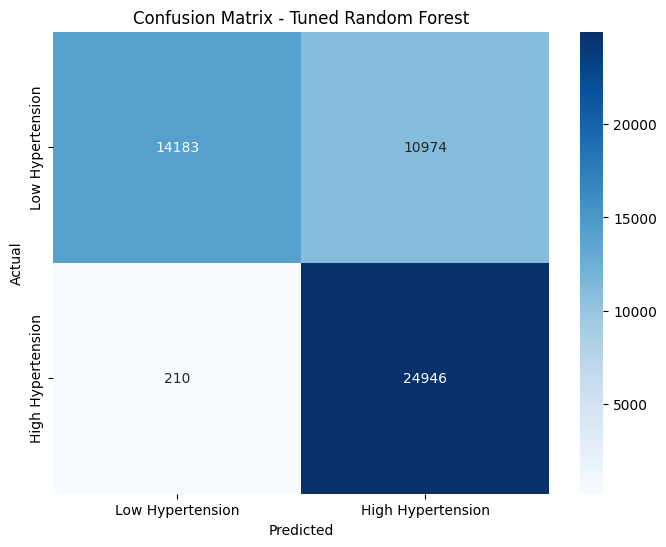

In [22]:
# Confusion Matrix for Tuned Model
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Hypertension', 'High Hypertension'],
            yticklabels=['Low Hypertension', 'High Hypertension'])
plt.title('Confusion Matrix - Tuned Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('./results/eda/random_forest_confusion_matrix.png')
plt.show()

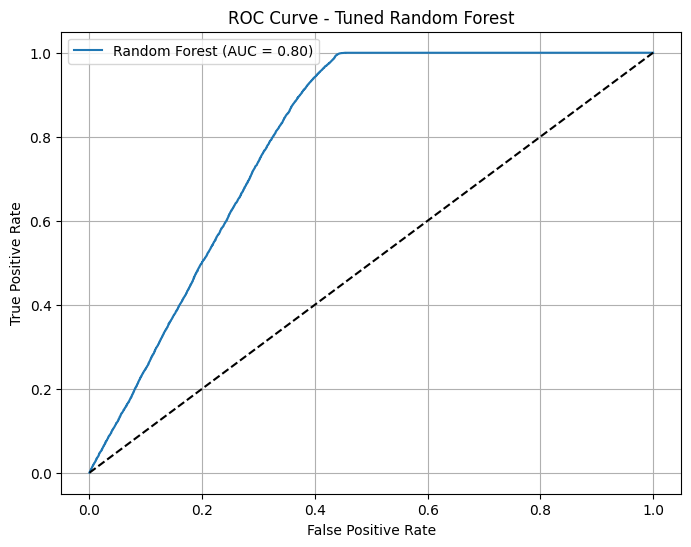

In [23]:
# ROC Curve for Tuned Model
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned)
auc_score = roc_auc_score(y_test, y_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest')
plt.legend()
plt.grid(True)
plt.savefig('./results/eda/random_forest_roc_curve.png')
plt.show()

In [24]:
# save evaluation details
model_name = "Random Forest" 

# create data frame for this model's metrics
model_metrics = pd.DataFrame({
    'Model': [
        f'{model_name} - Baseline', 
        f'{model_name} - Tuned'
    ],
    'Accuracy': [
        baseline_metrics['Accuracy'],
        tuned_metrics['Accuracy']
    ],
    'Precision': [
        baseline_metrics['Precision'],
        tuned_metrics['Precision']
    ],
    'Recall': [
        baseline_metrics['Recall'],
        tuned_metrics['Recall']
    ],
    'F1_Score': [
        baseline_metrics['F1 Score'],
        tuned_metrics['F1 Score']
    ],
    'AUC_ROC': [
        baseline_metrics['AUC-ROC'],
        tuned_metrics['AUC-ROC']
    ]
})

#  save model details
model_metrics.to_csv(f'./results/metrics/{model_name.lower().replace(" ", "_")}.csv', index=False)

In [25]:
# Save the tuned model
joblib.dump(tuned_rf, './results/models/random_forest_model_tuned.pkl')

print("Completed...!")

Completed...!
